In [1]:
import pandas as pd
import numpy as np
import warnings
import pyspark

warnings.simplefilter('ignore')

raw_prices = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Raw_prices.csv')
negocios = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Negocios.csv')
financeiro = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Financeiro.csv')
ibov = pd.read_csv(r'C:\Users\Andre\Documents\LowVolatility\Ibov_data.csv')

In [2]:
raw_prices['Datas'] = pd.to_datetime(raw_prices['Datas'])
precos_corte = raw_prices[(raw_prices['Datas'] >= '2000-01-01') & (raw_prices['Datas'] <= '2020-12-31')]
precos_corte.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5479 entries, 3652 to 9130
Columns: 1383 entries, Datas to ZIVI4
dtypes: datetime64[ns](1), float64(1382)
memory usage: 57.9 MB


In [3]:
long_data = precos_corte.melt(id_vars=['Datas'], var_name='Codigo', value_name='Preco')
long_data.head()

,Datas,Codigo,Preco
0,2000-01-03,RRRP3,NaN
1,2000-01-04,RRRP3,NaN
2,2000-01-05,RRRP3,NaN
3,2000-01-06,RRRP3,NaN
4,2000-01-07,RRRP3,NaN


In [4]:
long_data['Ano'] = long_data['Datas'].dt.year

In [5]:
# grouped_data = long_data.groupby(['Codigo', 'Ano'])

In [6]:
long_data['Total_Dias_Negociacao'] = long_data.groupby(['Codigo', 'Ano'])['Datas'].transform('nunique')
long_data['Pregoes'] = long_data.groupby(['Codigo', 'Ano'])['Preco'].transform(lambda x: x.notna().sum())
long_data['Pregoes_Percentual'] = long_data['Pregoes'] / long_data['Total_Dias_Negociacao']


In [7]:
long_data = long_data[long_data['Pregoes_Percentual'] > 0.9]

In [8]:
long_data = long_data.reset_index(drop=True)

In [9]:
long_data['Preco'] = long_data['Preco'].fillna(method='ffill')
long_data['Retorno'] = long_data.groupby('Codigo')['Preco'].pct_change()
long_data['Risco'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(
    lambda x: np.sqrt(len(x.dropna())) * np.nanstd(x, ddof=1)
)
long_data['Mean_Risco'] = long_data.groupby(['Codigo', 'Ano'])['Risco'].transform(lambda x: x.mean(skipna=True))

In [10]:
long_data['Retorno_positivos'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: (x > 0).sum())
long_data['Retorno_negativos'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: (x < 0).sum())
long_data['Perc_positivos'] = long_data['Retorno_positivos'] / (long_data['Retorno_positivos'] + long_data['Retorno_negativos'])
long_data['Perc_negativos'] = long_data['Retorno_negativos'] / (long_data['Retorno_positivos'] + long_data['Retorno_negativos'])
long_data['Retorno'] = long_data['Retorno'].fillna(0)
long_data['Retorno_Anual'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: np.prod(1 + x) - 1)
long_data['Retorno_acumulado'] = long_data.groupby('Codigo')['Retorno'].transform(lambda x: (1 + x).cumprod() - 1)
long_data['FIP'] = long_data['Perc_negativos'] - long_data['Perc_positivos']

In [11]:
dados_agregados = long_data.groupby(['Codigo', 'Ano']).agg({'Retorno_Anual':'first', 'Risco':'first', 'FIP':'first'}).reset_index()

In [12]:
dados_agregados['Decil_Retorno'] = dados_agregados.groupby('Ano')['Retorno_Anual'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_Risco'] = dados_agregados.groupby('Ano')['Risco'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_FIP'] = dados_agregados.groupby(['Codigo', 'Ano'])['FIP'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)

In [13]:
dados_agregados['Decil_Retorno'] = dados_agregados.groupby('Ano')['Retorno_Anual'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_Risco'] = dados_agregados.groupby('Ano')['Risco'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_FIP'] = dados_agregados.groupby('Ano')['FIP'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)


In [14]:
long_data = pd.merge(long_data, dados_agregados[['Codigo', 'Ano', 'Decil_Retorno', 'Decil_Risco', 'Decil_FIP']], on=['Codigo', 'Ano'], how='left')

In [15]:
long_data['Retorno_Medio'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: x.mean(skipna=True))

In [16]:
long_data

,Datas,Codigo,Preco,Ano,Total_Dias_Negociacao,Pregoes,Pregoes_Percentual,Retorno,Risco,Mean_Risco,...,Retorno_negativos,Perc_positivos,Perc_negativos,Retorno_Anual,Retorno_acumulado,FIP,Decil_Retorno,Decil_Risco,Decil_FIP,Retorno_Medio
0,2008-01-01,ABCB4,NaN,2008,262,249,0.950382,0.000000,0.647118,0.647118,...,131,0.460905,0.539095,-0.552452,0.000000,0.078189,5,4,4,-0.002269
1,2008-01-02,ABCB4,9.901598,2008,262,249,0.950382,0.000000,0.647118,0.647118,...,131,0.460905,0.539095,-0.552452,0.000000,0.078189,5,4,4,-0.002269
2,2008-01-03,ABCB4,9.651906,2008,262,249,0.950382,-0.025217,0.647118,0.647118,...,131,0.460905,0.539095,-0.552452,-0.025217,0.078189,5,4,4,-0.002269
3,2008-01-04,ABCB4,9.341943,2008,262,249,0.950382,-0.032114,0.647118,0.647118,...,131,0.460905,0.539095,-0.552452,-0.056522,0.078189,5,4,4,-0.002269
4,2008-01-07,ABCB4,9.083640,2008,262,249,0.950382,-0.027650,0.647118,0.647118,...,131,0.460905,0.539095,-0.552452,-0.082609,0.078189,5,4,4,-0.002269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045625,2020-12-25,YDUQ3,34.393617,2020,262,249,0.950382,0.000000,0.758910,0.758910,...,130,0.473684,0.526316,-0.324402,-0.002390,0.052632,3,7,7,-0.000397
1045626,2020-12-28,YDUQ3,34.571281,2020,262,249,0.950382,0.005166,0.758910,0.758910,...,130,0.473684,0.526316,-0.324402,0.002763,0.052632,3,7,7,-0.000397
1045627,2020-12-29,YDUQ3,34.759396,2020,262,249,0.950382,0.005441,0.758910,0.758910,...,130,0.473684,0.526316,-0.324402,0.008219,0.052632,3,7,7,-0.000397
1045628,2020-12-30,YDUQ3,33.945800,2020,262,249,0.950382,-0.023407,0.758910,0.758910,...,130,0.473684,0.526316,-0.324402,-0.015379,0.052632,3,7,7,-0.000397


In [17]:
# long_data = long_data.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Preco'], axis=1)

In [18]:
# long_data_2 = long_data.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Preco'], axis=1)

In [19]:
negocios['Datas'] = pd.to_datetime(negocios['Datas'])
negocios = negocios[(negocios['Datas'] >= '2000-01-01') & (negocios['Datas'] <= '2020-12-31')]
negocios = negocios.melt(id_vars=['Datas'], var_name='Codigo', value_name='Negocios')
negocios['Ano'] = negocios['Datas'].dt.year
negocios['Media_Negocios_Acao'] = negocios.groupby(['Codigo', 'Ano'])['Negocios'].transform(lambda x: x.mean(skipna=True))
negocios['Dias_Negocios'] = negocios.groupby(['Codigo', 'Ano'])['Negocios'].transform(lambda x: x.notna().sum())
dias_por_ano = negocios.groupby('Ano')['Datas'].nunique().rename('Total_Dias_Negociacao')
negocios = negocios.merge(dias_por_ano, on='Ano', how='left')
negocios['Negocios_Percentual'] = negocios['Dias_Negocios'] / negocios['Total_Dias_Negociacao']
negocios = negocios[negocios['Negocios_Percentual'] > 0.9]
negocios['Media_Negocios'] = negocios.groupby('Ano')['Negocios'].transform(lambda x: x.mean(skipna=True))
negocios['Razao_Media_Negocios'] = negocios['Media_Negocios_Acao'] / negocios['Media_Negocios']

In [20]:
negocios.head()

,Datas,Codigo,Negocios,Ano,Media_Negocios_Acao,Dias_Negocios,Total_Dias_Negociacao,Negocios_Percentual,Media_Negocios,Razao_Media_Negocios
40439,2008-01-01,ABCB4,NaN,2008,56.943775,249,262,0.950382,738.928937,0.077063
40440,2008-01-02,ABCB4,42.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40441,2008-01-03,ABCB4,10.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40442,2008-01-04,ABCB4,23.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40443,2008-01-07,ABCB4,18.0,2008,56.943775,249,262,0.950382,738.928937,0.077063


In [21]:
negocios_2 = negocios.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Negocios'], axis=1)

In [22]:
financeiro['Datas'] = pd.to_datetime(financeiro['Datas'])
financeiro = financeiro[(financeiro['Datas'] >= '2000-01-01') & (financeiro['Datas'] <= '2020-12-31')]


In [23]:
financeiro = financeiro.melt(id_vars=['Datas'], var_name='Codigo', value_name='Financeiro')

In [24]:
financeiro['Ano'] = financeiro['Datas'].dt.year

In [25]:
financeiro['Media_Financeiro_Ativo_Ano'] = financeiro.groupby(['Codigo', 'Ano'])['Financeiro'].transform(lambda x: x.mean(skipna=True))

In [26]:
financeiro['Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano'])['Financeiro'].transform(lambda x: x.notna().sum())

In [27]:
financeiro['Total_Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano'])['Datas'].transform(lambda x: x.nunique())

In [28]:
financeiro['Financeiro_Dias_Percentual'] = financeiro['Financeiro_Dias'] / financeiro['Total_Financeiro_Dias']

In [29]:
financeiro = financeiro[financeiro['Financeiro_Dias_Percentual'] > 0.9]

In [30]:
financeiro['Media_Financeiro_Ano'] = financeiro.groupby('Ano')['Financeiro'].transform(lambda x: x.mean(skipna=True))
financeiro['DP_Financeiro_Ano'] = financeiro.groupby('Ano')['Financeiro'].transform(lambda x: x.std(skipna=True))

In [31]:
financeiro['Razao_Financeiro'] = financeiro['Media_Financeiro_Ativo_Ano'] / financeiro['Media_Financeiro_Ano']

In [32]:
financeiro_2 = financeiro.groupby(['Codigo', 'Ano']).first().reset_index().drop('Financeiro', axis=1)

In [33]:
df = long_data.merge(negocios_2, on=['Codigo', 'Ano'], how='left')

In [34]:
df = df.merge(financeiro_2, on=['Codigo', 'Ano'], how='left')

In [35]:
df = df.drop(['Total_Dias_Negociacao_y', 'Datas_y', 'Datas'], axis=1).rename(columns={'Datas_x':'Datas', 'Total_Dias_Negociacao_x':'Total_Dias_Negociacao'})

In [36]:
ibov['Datas'] = pd.to_datetime(ibov['Datas'])
ibov = ibov[(ibov['Datas'] >= '2000-01-01') & (ibov['Datas'] <= '2020-12-31')]
ibov['Pontos'] = ibov['Pontos'].fillna(method='ffill')
ibov['Retorno'] = ibov['Pontos'].pct_change()


In [37]:
ibov['Retorno'] = ibov['Retorno'].fillna(0)

In [38]:
ibov['Ret_Acumulado_Carteira'] = (1 + ibov['Retorno']).cumprod() - 1

In [39]:
ibov['Ano'] = ibov['Datas'].dt.year

In [40]:
ibov = ibov.reset_index(drop=True)

In [41]:
df_filtrado = df[(df['Razao_Financeiro'] > 0.05) & (df['Razao_Media_Negocios'] > 0.01)]

In [42]:
lista_dfs = [grupo.reset_index(drop=True) for _, grupo in df_filtrado.groupby('Ano')]

In [43]:
lista_dfs

[           Datas Codigo       Preco   Ano  Total_Dias_Negociacao  Pregoes  \
 0     2000-01-03  GETI4    1.847720  2000                    260      243   
 1     2000-01-04  GETI4    1.802209  2000                    260      243   
 2     2000-01-05  GETI4    1.875026  2000                    260      243   
 3     2000-01-06  GETI4    1.811312  2000                    260      243   
 4     2000-01-07  GETI4    1.858642  2000                    260      243   
 ...          ...    ...         ...   ...                    ...      ...   
 24955 2000-12-25  VIVO4  507.222123  2000                    260      248   
 24956 2000-12-26  VIVO4  509.268421  2000                    260      248   
 24957 2000-12-27  VIVO4  532.544852  2000                    260      248   
 24958 2000-12-28  VIVO4  522.555586  2000                    260      248   
 24959 2000-12-29  VIVO4  522.555586  2000                    260      248   
 
        Pregoes_Percentual   Retorno     Risco  Mean_Risco  ..

In [44]:
Lista_Carteira_Mercado = []

for df in lista_dfs:
    agrupado = df.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    Lista_Carteira_Mercado.append(agrupado)


In [45]:
lista_carteira_1 = []
lista_carteira_2 = []
lista_carteira_3 = []
lista_carteira_4 = []
lista_carteira_5 = []

for df in lista_dfs:
    # Para a Carteira 1
    filtrado_1 = df[df['Decil_Risco'] <= 1]
    agregado_1 = filtrado_1.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_1.append(agregado_1)

    # Para a Carteira 2
    filtrado_2 = df[(df['Decil_Risco'] <= 2) & (df['Decil_Risco'] > 1)]
    agregado_2 = filtrado_2.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_2.append(agregado_2)

    # Para a Carteira 3
    filtrado_3 = df[(df['Decil_Risco'] <= 3) & (df['Decil_Risco'] > 2)]
    agregado_3 = filtrado_3.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_3.append(agregado_3)

    # Para a Carteira 4
    filtrado_4 = df[(df['Decil_Risco'] <= 4) & (df['Decil_Risco'] > 3)]
    agregado_4 = filtrado_4.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_4.append(agregado_4)

    # Para a Carteira 5
    filtrado_5 = df[(df['Decil_Risco'] <= 5) & (df['Decil_Risco'] > 4)]
    agregado_5 = filtrado_5.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_5.append(agregado_5)


In [46]:
lista_carteira_1[0]

,Codigo,Risco,Retorno_Anual,Decil_Retorno,Decil_Risco,Ano
0,BBAS3,0.369741,-0.285487,3.0,1.0,2000.0
1,BDLL4,0.360847,0.015736,7.0,1.0,2000.0
2,BRKM5,0.395469,0.088635,8.0,1.0,2000.0
3,ELET3,0.392971,-0.127976,5.0,1.0,2000.0
4,ITSA4,0.365302,0.004337,7.0,1.0,2000.0
5,PCAR4,0.368936,0.091606,8.0,1.0,2000.0
6,PETR4,0.387445,-0.064319,6.0,1.0,2000.0
7,TBLE6,0.357627,0.400693,9.0,1.0,2000.0
8,TEBA5,0.373339,0.418961,9.0,1.0,2000.0
9,TMGR6,0.370583,0.412478,9.0,1.0,2000.0


In [47]:
lista_trade_neutro = []
pd.set_option('display.max_columns', 100)
for i in range(1, 21):  # Ajuste para iniciar de 1 até 20, correspondente ao código R
    df_filtrado = lista_dfs[i]['Codigo'].isin(Lista_Carteira_Mercado[i-1]['Codigo'])
    df_filtrado = lista_dfs[i][df_filtrado]

  
    df_agrupado = df_filtrado.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()

    # Cálculo do retorno acumulado
    df_agrupado['Ret_Acumulado_Carteira'] = (1 + df_agrupado['Retorno_Carteira']).cumprod() - 1

    lista_trade_neutro.append(df_agrupado)

In [49]:
lista_trade_1 = []
lista_trade_2 = []
lista_trade_3 = []
lista_trade_4 = []
lista_trade_5 = []

for i in range(1, 21):
    df1 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_1[i-1]['Codigo'])]
    df1_grouped = df1.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df1_grouped['Ret_Acumulado_Carteira'] = (1 + df1_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_1.append(df1_grouped)
    
for i in range(1, 21):
    df2 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_2[i-1]['Codigo'])]
    df2_grouped = df2.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df2_grouped['Ret_Acumulado_Carteira'] = (1 + df2_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_2.append(df2_grouped)

for i in range(1, 21):
    df3 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_3[i-1]['Codigo'])]
    df3_grouped = df3.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df3_grouped['Ret_Acumulado_Carteira'] = (1 + df3_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_3.append(df3_grouped)
    
for i in range(1, 21):
    df4 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_4[i-1]['Codigo'])]
    df4_grouped = df4.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df4_grouped['Ret_Acumulado_Carteira'] = (1 + df4_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_4.append(df4_grouped)
    
for i in range(1, 21):
    df5 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_5[i-1]['Codigo'])]
    df5_grouped = df5.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df5_grouped['Ret_Acumulado_Carteira'] = (1 + df5_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_5.append(df5_grouped)

In [50]:
lista_ibovespa = [grupo.reset_index(drop=True) for _, grupo in ibov.groupby('Ano')]

In [51]:
lista_ibovespa_2 = []
for i in range(21):
    df_ibov = lista_ibovespa[i].copy()
    df_ibov['Ret_Acumulado_Carteira'] = (1 + df_ibov['Retorno']).cumprod() - 1
    lista_ibovespa_2.append(df_ibov)

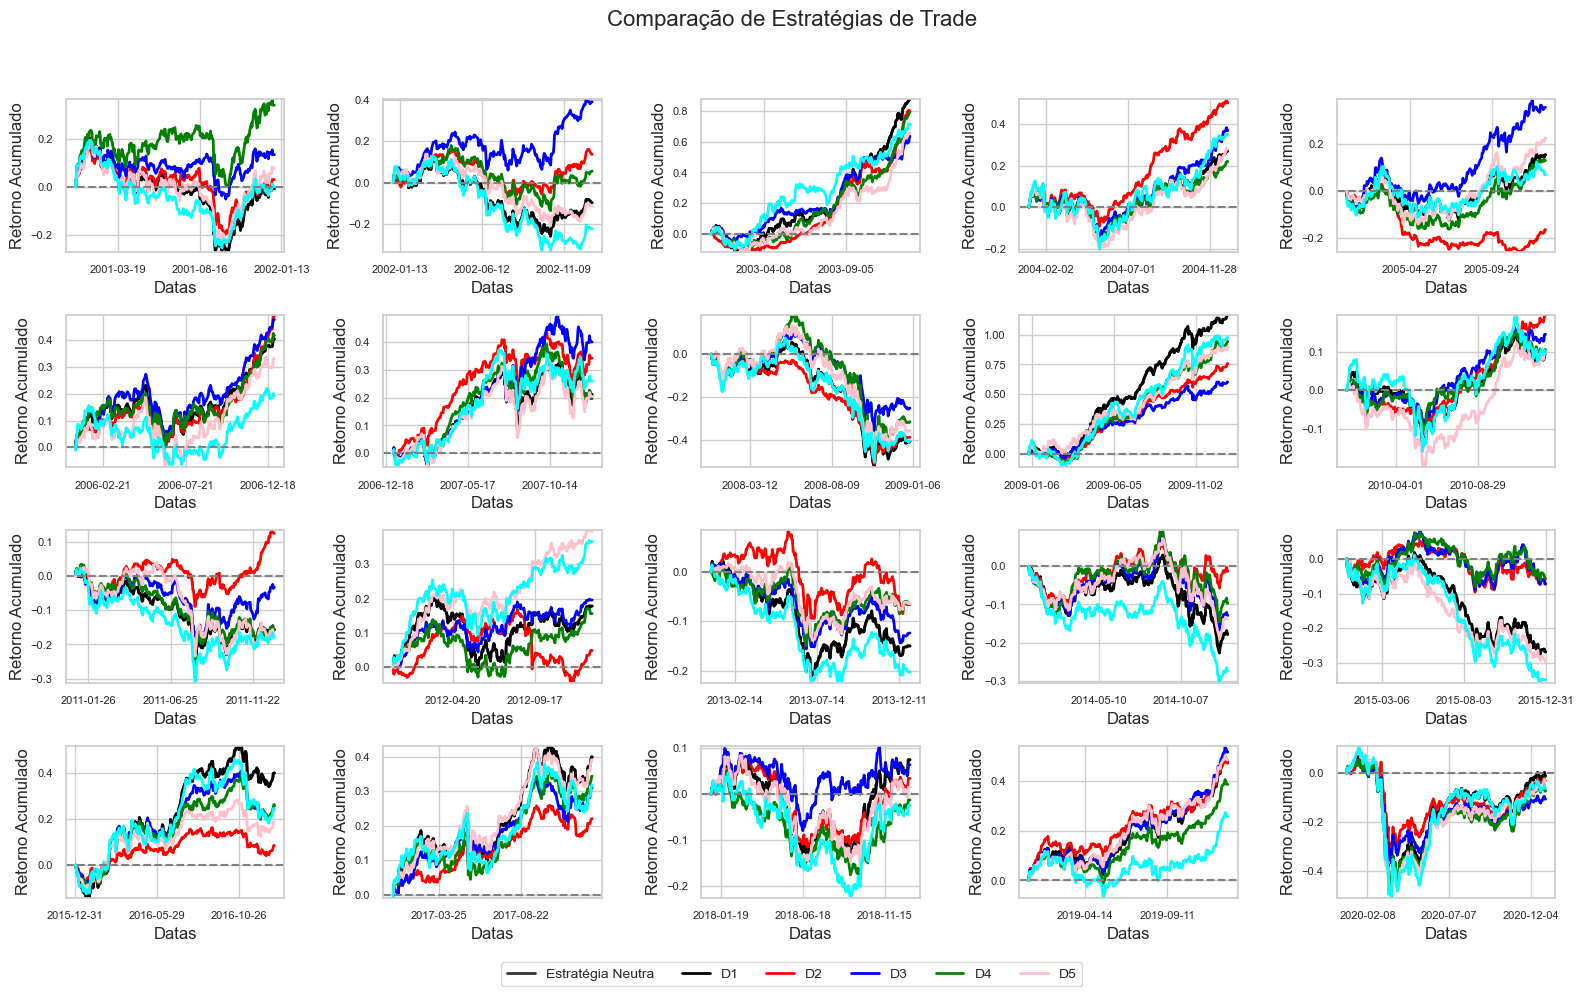

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid")

# Configurando o layout do gráfico
fig, axes = plt.subplots(4, 5, figsize=(16, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(lista_trade_neutro):
        break
    ax.plot(lista_trade_neutro[i]['Datas'], lista_trade_neutro[i]['Ret_Acumulado_Carteira'], label='Estratégia Neutra', color='black', linewidth=2, alpha=0.8)
    ax.plot(lista_trade_neutro[i]['Datas'], lista_trade_neutro[i]['Ret_Acumulado_Carteira'], label='Estratégia Neutra', color='black', linewidth=2)
    ax.plot(lista_trade_1[i]['Datas'], lista_trade_1[i]['Ret_Acumulado_Carteira'], label='D1', color='red', linewidth=2)
    ax.plot(lista_trade_2[i]['Datas'], lista_trade_2[i]['Ret_Acumulado_Carteira'], label='D2', color='blue', linewidth=2)
    ax.plot(lista_trade_3[i]['Datas'], lista_trade_3[i]['Ret_Acumulado_Carteira'], label='D3', color='green', linewidth=2)
    ax.plot(lista_trade_4[i]['Datas'], lista_trade_4[i]['Ret_Acumulado_Carteira'], label='D4', color='pink', linewidth=2)
    ax.plot(lista_trade_5[i]['Datas'], lista_trade_5[i]['Ret_Acumulado_Carteira'], label='D5', color='cyan', linewidth=2)
    
    ax.set_xlabel('Datas', fontsize=12)
    ax.set_ylabel('Retorno Acumulado', fontsize=12)
    ax.axhline(y=0, color='grey', linestyle='--')
    
    y_min = min([min(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    y_max = max([max(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    ax.set_ylim([y_min, y_max])

    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.figlegend(['Estratégia Neutra', 'D1', 'D2', 'D3', 'D4', 'D5'], loc='lower center', ncol=6, labelspacing=0., fontsize=10)
plt.suptitle("Comparação de Estratégias de Trade", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [53]:
port_trade_neutro = pd.concat(lista_trade_neutro)
port_trade_neutro['Ret_Acumulado_Carteira'] = (1 + port_trade_neutro['Retorno_Carteira']).cumprod() - 1

port_trade_1 = pd.concat(lista_trade_1)
port_trade_1['Ret_Acumulado_Carteira'] = (1 + port_trade_1['Retorno_Carteira']).cumprod() - 1

port_trade_2 = pd.concat(lista_trade_2)
port_trade_2['Ret_Acumulado_Carteira'] = (1 + port_trade_2['Retorno_Carteira']).cumprod() - 1

port_trade_3 = pd.concat(lista_trade_3)
port_trade_3['Ret_Acumulado_Carteira'] = (1 + port_trade_3['Retorno_Carteira']).cumprod() - 1

port_trade_4 = pd.concat(lista_trade_4)
port_trade_4['Ret_Acumulado_Carteira'] = (1 + port_trade_4['Retorno_Carteira']).cumprod() - 1

port_trade_5 = pd.concat(lista_trade_5)
port_trade_5['Ret_Acumulado_Carteira'] = (1 + port_trade_5['Retorno_Carteira']).cumprod() - 1


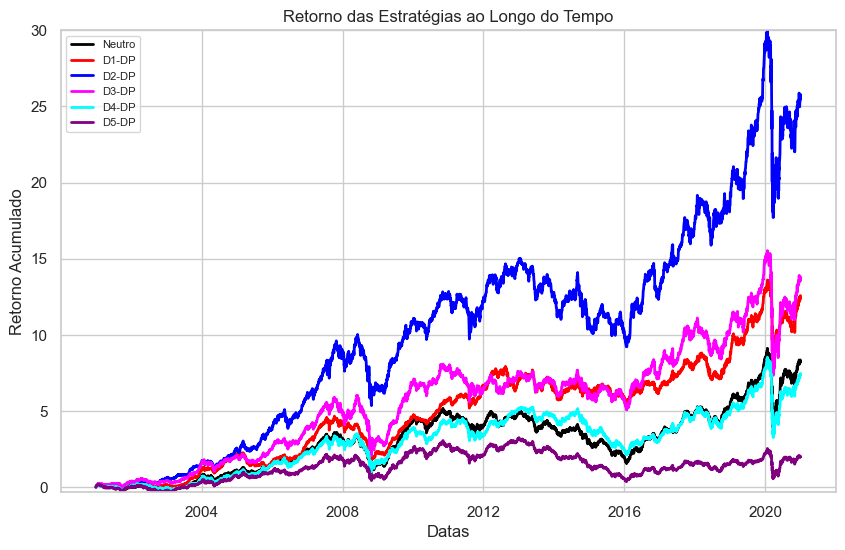

In [54]:
plt.figure(figsize=(10, 6))

# Plotando as linhas para cada conjunto de dados
plt.plot(port_trade_neutro['Datas'], port_trade_neutro['Ret_Acumulado_Carteira'], label='Neutro', color='black', linewidth=2)
plt.plot(port_trade_1['Datas'], port_trade_1['Ret_Acumulado_Carteira'], label='D1-DP', color='red', linewidth=2)
plt.plot(port_trade_2['Datas'], port_trade_2['Ret_Acumulado_Carteira'], label='D2-DP', color='blue', linewidth=2)
plt.plot(port_trade_3['Datas'], port_trade_3['Ret_Acumulado_Carteira'], label='D3-DP', color='magenta', linewidth=2)
plt.plot(port_trade_4['Datas'], port_trade_4['Ret_Acumulado_Carteira'], label='D4-DP', color='cyan', linewidth=2)
plt.plot(port_trade_5['Datas'], port_trade_5['Ret_Acumulado_Carteira'], label='D5-DP', color='purple', linewidth=2)

# Configurando os limites do eixo y
y_min = min([port_trade_neutro['Ret_Acumulado_Carteira'].min(), port_trade_1['Ret_Acumulado_Carteira'].min(),
             port_trade_2['Ret_Acumulado_Carteira'].min(), port_trade_3['Ret_Acumulado_Carteira'].min(),
             port_trade_4['Ret_Acumulado_Carteira'].min(), port_trade_5['Ret_Acumulado_Carteira'].min()])

y_max = max([port_trade_neutro['Ret_Acumulado_Carteira'].max(), port_trade_1['Ret_Acumulado_Carteira'].max(),
             port_trade_2['Ret_Acumulado_Carteira'].max(), port_trade_3['Ret_Acumulado_Carteira'].max(),
             port_trade_4['Ret_Acumulado_Carteira'].max(), port_trade_5['Ret_Acumulado_Carteira'].max()])

plt.ylim([y_min, 30])

# Adicionando rótulos e título
plt.xlabel('Datas')
plt.ylabel('Retorno Acumulado')
plt.title('Retorno das Estratégias ao Longo do Tempo')

# Adicionando uma grade de fundo
plt.grid(True)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [55]:
# Creating the Data_DF_Final DataFrame
Data_DF_Final = pd.DataFrame({
    'Datas': port_trade_1['Datas'],
    'Trade1': port_trade_1['Retorno_Carteira'],
    'Trade2': port_trade_2['Retorno_Carteira'],
    'Trade3': port_trade_3['Retorno_Carteira'],
    'Trade4': port_trade_4['Retorno_Carteira'],
    'Trade5': port_trade_5['Retorno_Carteira'],
    'Neutro': port_trade_neutro['Retorno_Carteira']
})

# Creating time series
xts_Trade1 = pd.Series(port_trade_1['Retorno_Carteira'].values, index=port_trade_1['Datas'])
xts_Trade2 = pd.Series(port_trade_2['Retorno_Carteira'].values, index=port_trade_2['Datas'])
xts_Trade3 = pd.Series(port_trade_3['Retorno_Carteira'].values, index=port_trade_3['Datas'])
xts_Trade4 = pd.Series(port_trade_4['Retorno_Carteira'].values, index=port_trade_4['Datas'])
xts_Trade5 = pd.Series(port_trade_5['Retorno_Carteira'].values, index=port_trade_5['Datas'])
xts_TradeNeutro = pd.Series(port_trade_neutro['Retorno_Carteira'].values, index=port_trade_neutro['Datas'])
xts_Ibov = pd.Series(ibov['Retorno'].values, index=ibov['Datas'])

In [56]:
xts_vector = pd.concat([xts_Trade1, xts_Trade2, xts_Trade3, xts_Trade4, xts_Trade5,
                        xts_TradeNeutro, xts_Ibov], axis=1)

# Filtrando os dados para datas após 31/12/2000
xts_vector = xts_vector[xts_vector.index > "2000-12-31"]

In [57]:
xts_vector.columns = ['D1', 'D2', 'D3', 'D4', 'D5', 'Neutro', 'Ibovespa']

In [59]:
import scipy.stats as stats

def semi_deviation(returns):
    return np.std(returns[returns < 0])

def gain_deviation(returns):
    return np.std(returns[returns > 0])

def loss_deviation(returns):
    return np.std(np.abs(returns[returns < 0]))

def downside_deviation(returns, mar=0):
    return np.sqrt(np.mean(np.minimum(0, returns - mar)**2))

def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

def historical_var(returns, confidence_level=0.95):
    if isinstance(returns, pd.DataFrame):
        return returns.quantile(1 - confidence_level)
    else:
        return np.percentile(returns, 100 * (1 - confidence_level))

def historical_es(returns, confidence_level=0.95):
    var = historical_var(returns, confidence_level)
    return returns[returns <= var].mean()

def modified_var(returns, confidence_level=0.95):
    z = stats.norm.ppf(1 - confidence_level)
    return -np.mean(returns) - z * stats.kurtosis(returns)**0.5

def modified_es(returns, confidence_level=0.95):
    var = modified_var(returns, confidence_level)
    return returns[returns <= var].mean()

# Calculando as métricas de risco para cada série temporal no dataframe de trades
metrics = { 'Semi Deviation': semi_deviation,
    'Gain Deviation': gain_deviation,
    'Loss Deviation': loss_deviation,
    'Downside Deviation (Rf=0%)': lambda x: downside_deviation(x, mar=0),    
    'Maximum Drawdown': max_drawdown,
    'Historical VaR (95%)': lambda x: historical_var(x, confidence_level=0.95),
    'Historical ES (95%)': lambda x: historical_es(x, confidence_level=0.95)
#     'Modified VaR (95%)': lambda x: modified_var(x, confidence_level=0.95),
#     'Modified ES (95%)': lambda x: modified_es(x, confidence_level=0.95)
}

# Criando um dataframe para as métricas
risk_metrics_df = pd.DataFrame({metric: xts_vector.apply(func) for metric, func in metrics.items()})

# Transpondo o dataframe para o formato de dados correto
risk_metrics_df = risk_metrics_df.T

In [61]:
risk_metrics_df

,D1,D2,D3,D4,D5,Neutro,Ibovespa
Semi Deviation,0.009109,0.009922,0.011580,0.012491,0.013309,0.011893,0.012931
Gain Deviation,0.007620,0.009011,0.010276,0.011070,0.012103,0.010026,0.012173
Loss Deviation,0.009109,0.009922,0.011580,0.012491,0.013309,0.011893,0.012931
Downside Deviation (Rf=0%),0.008045,0.009058,0.010364,0.011241,0.012301,0.010665,0.012305
Maximum Drawdown,-0.546035,-0.423632,-0.563045,-0.555597,-0.673718,-0.583337,-0.599611
Historical VaR (95%),-0.016549,-0.018619,-0.021014,-0.023799,-0.025253,-0.022511,-0.026998
Historical ES (95%),-0.026512,-0.029664,-0.033995,-0.036696,-0.040078,-0.034783,-0.039980


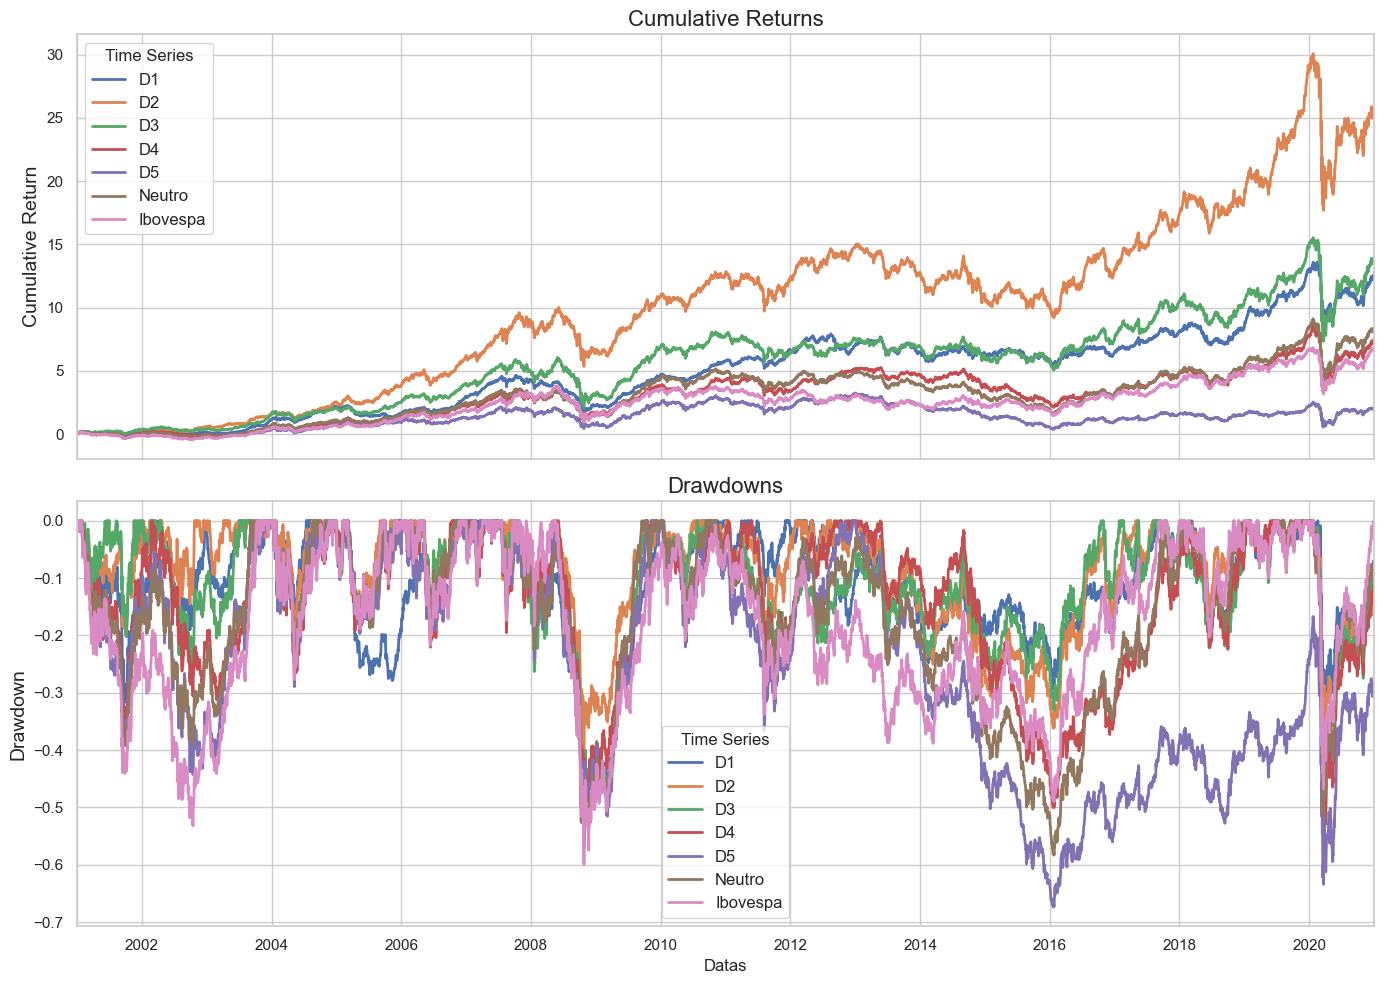

In [60]:
def cumulative_returns(returns):
    """Calcula o retorno acumulado de uma série de retornos."""
    return (1 + returns).cumprod() - 1

def drawdowns(returns):
    """Calcula o drawdown."""
    cumulative = (1 + returns).cumprod()
    max_cumulative = cumulative.cummax()
    return (cumulative - max_cumulative) / max_cumulative

def plot_performance_summary(returns):
    """
    Plotando o resumo de performance incluindo retorno acumulado e drawdowns
    
    :param returns_df: DataFrame of returns
    """
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Retorno Acumulado
    cum_returns_df = returns.apply(cumulative_returns)
    cum_returns_df.plot(ax=axes[0], linewidth=2)
    axes[0].set_title('Cumulative Returns', fontsize=16)
    axes[0].set_ylabel('Cumulative Return', fontsize=14)
    axes[0].legend(title='Time Series', fontsize=12)

    # Drawdowns
    drawdowns_df = returns.apply(drawdowns)
    drawdowns_df.plot(ax=axes[1], linewidth=2)
    axes[1].set_title('Drawdowns', fontsize=16)
    axes[1].set_ylabel('Drawdown', fontsize=14)
    axes[1].legend(title='Time Series', fontsize=12)

    # Setando o layout 
    plt.tight_layout()
    plt.show()

plot_performance_summary(xts_vector)

In [62]:
def annualized_return(returns):
    """Calcula o retorno anualizado de uma série de retornos."""
    compounded_return = np.prod(1 + returns) ** (1 / len(returns)) - 1
    return (1 + compounded_return) ** 252 - 1  # 252 trading days in a year

def annualized_std_dev(returns):
    """Calcula o desvio padrão anualizado de uma série de retornos."""
    return np.std(returns) * np.sqrt(252)

def annualized_sharpe_ratio(returns, risk_free_rate=0):
    """Calcula o Índice Sharpe de uma série de retornos"""
    excess_return = annualized_return(returns) - risk_free_rate
    return excess_return / annualized_std_dev(returns)

# Calculando as métricas para cada série temporal no dataframe
annualized_metrics = {
    'Annualized Return': lambda x: annualized_return(x),
    'Annualized Std Dev': lambda x: annualized_std_dev(x),
    'Annualized Sharpe (Rf=0%)': lambda x: annualized_sharpe_ratio(x)
}

# Criando um dataframe para as metricas anualizadas
annualized_metrics_df = pd.DataFrame({metric: xts_vector.apply(func) for metric, func in annualized_metrics.items()})

# Transpondo o dataframe para o formato de dados correto
annualized_metrics_df = annualized_metrics_df.T


In [63]:
annualized_metrics_df

,D1,D2,D3,D4,D5,Neutro,Ibovespa
Annualized Return,0.133428,0.171353,0.138043,0.108010,0.054243,0.113210,0.104268
Annualized Std Dev,0.178756,0.206313,0.232525,0.250602,0.273636,0.235304,0.278269
Annualized Sharpe (Rf=0%),0.746423,0.830549,0.593672,0.431000,0.198229,0.481122,0.374701


<Figure size 1600x1000 with 0 Axes>

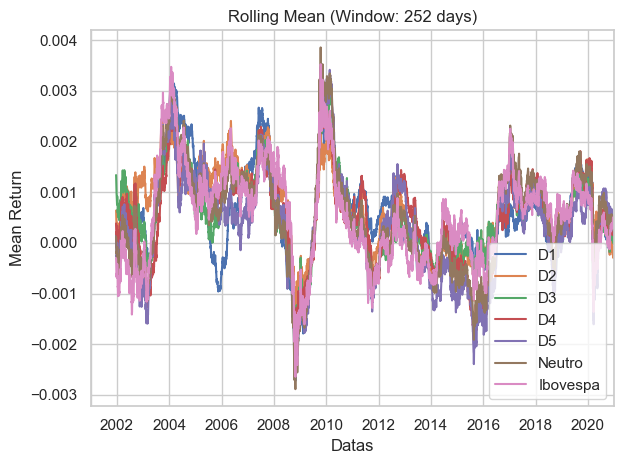

In [64]:
def plot_rolling_performance(returns_df, window=252, title='Rolling Performance'):
    """
    Plot rolling performance metrics for a DataFrame of returns.
    
    :param returns_df: DataFrame of returns
    :param window: Rolling window size (in days)
    :param title: Chart title
    """
    rolling_mean = returns_df.rolling(window=window).mean()

    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(16,10))

    rolling_mean.plot(title=f'Rolling Mean (Window: {window} days)')
    plt.ylabel('Mean Return')
    plt.tight_layout()
    plt.show()


plot_rolling_performance(xts_vector, window=252)


In [65]:
ret_sq = xts_vector ** 2
lambda_ = 0.95
EWMA_Estimado = ret_sq.ewm(span=(2/(1-lambda_)), adjust=False).mean()

In [66]:
Mov_SD = xts_vector.rolling(window=252, min_periods=1).std()

In [67]:
Mov_SD

,D1,D2,D3,D4,D5,Neutro,Ibovespa
Datas,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,0.004076,0.004343,0.009766,0.001796,0.023725,0.004615,0.007692
2001-01-03,0.029662,0.028293,0.038081,0.036353,0.026794,0.038776,0.041163
2001-01-04,0.027318,0.023241,0.033787,0.031794,0.025796,0.033961,0.035758
2001-01-05,0.025748,0.023332,0.030146,0.029224,0.025093,0.031748,0.035507
...,...,...,...,...,...,...,...
2020-12-25,0.021908,0.024791,0.029185,0.031957,0.035165,0.029969,0.027858
2020-12-28,0.021934,0.024820,0.029190,0.031972,0.035167,0.029979,0.027865
2020-12-29,0.021930,0.024819,0.029189,0.031977,0.035178,0.029980,0.027864


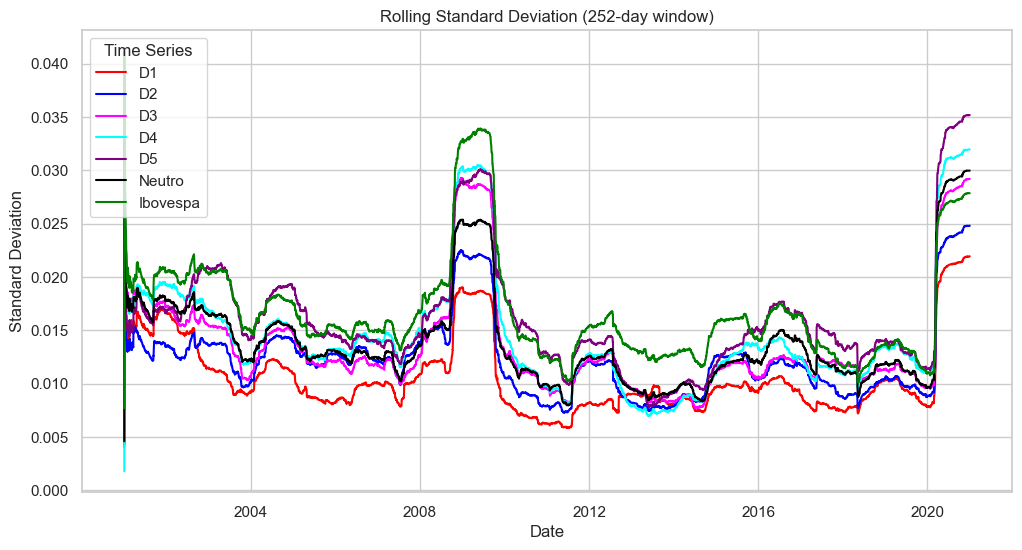

In [68]:
colors = ["red", "blue", "magenta", "cyan", "purple", "black", "green"]

plt.figure(figsize=(12, 6))
for col, color in zip(Mov_SD.columns, colors):
    plt.plot(Mov_SD.index, Mov_SD[col], label=col, color=color)

plt.title('Rolling Standard Deviation (252-day window)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend(title='Time Series')
plt.show()